In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning


### Load data

In [2]:
data  = pd.read_excel('../data/baraka_hygienics_2023-24.xlsx', sheet_name="Expenditure per year")
df = data.groupby('Years').apply(lambda x: pd.Series({'Cost':  x['Total'].sum(),
                                                      'Sales': x['Sales'].sum(),
                                                      'Profit': x['Profit'].sum()
                                                     }), 
                                 include_groups=False).reset_index().rename(columns ={'Years': 'Month'}); df

,Month,Cost,Sales,Profit
0,2023-06-01,35027.0,54350.0,19323.0
1,2023-07-01,48065.0,66417.0,18352.0
2,2023-08-01,18370.0,51712.0,33342.0
3,2023-09-01,37480.0,59582.0,22102.0
4,2023-10-01,23390.0,89290.0,65900.0
5,2023-11-01,24200.0,50590.0,26390.0
6,2023-12-01,13748.0,48415.0,34667.0
7,2024-01-01,16720.0,40837.0,24117.0
8,2024-02-01,23905.0,31339.0,7434.0
9,2024-03-01,24914.0,52790.0,27876.0


### Time-series

__Observations__

The dataset spans one year from June 2023 to June 2024.
Profit has significant variability, ranging from a loss of -6,023 to a high of 65,900.
Sales and cost also show considerable fluctuation, which may indicate seasonal impacts or market volatility.

In [3]:
df.set_index('Month', inplace=True)
df.describe()

,Cost,Sales,Profit
count,13.000000,13.000000,13.000000
mean,26390.923077,51747.615385,25356.692308
std,9380.798815,17267.954345,16383.775783
min,13748.000000,15850.000000,-6023.000000
25%,21873.000000,48415.000000,19323.000000
50%,24160.000000,52790.000000,26390.000000
75%,31230.000000,58537.000000,28850.000000
max,48065.000000,89290.000000,65900.000000


### Correlogram

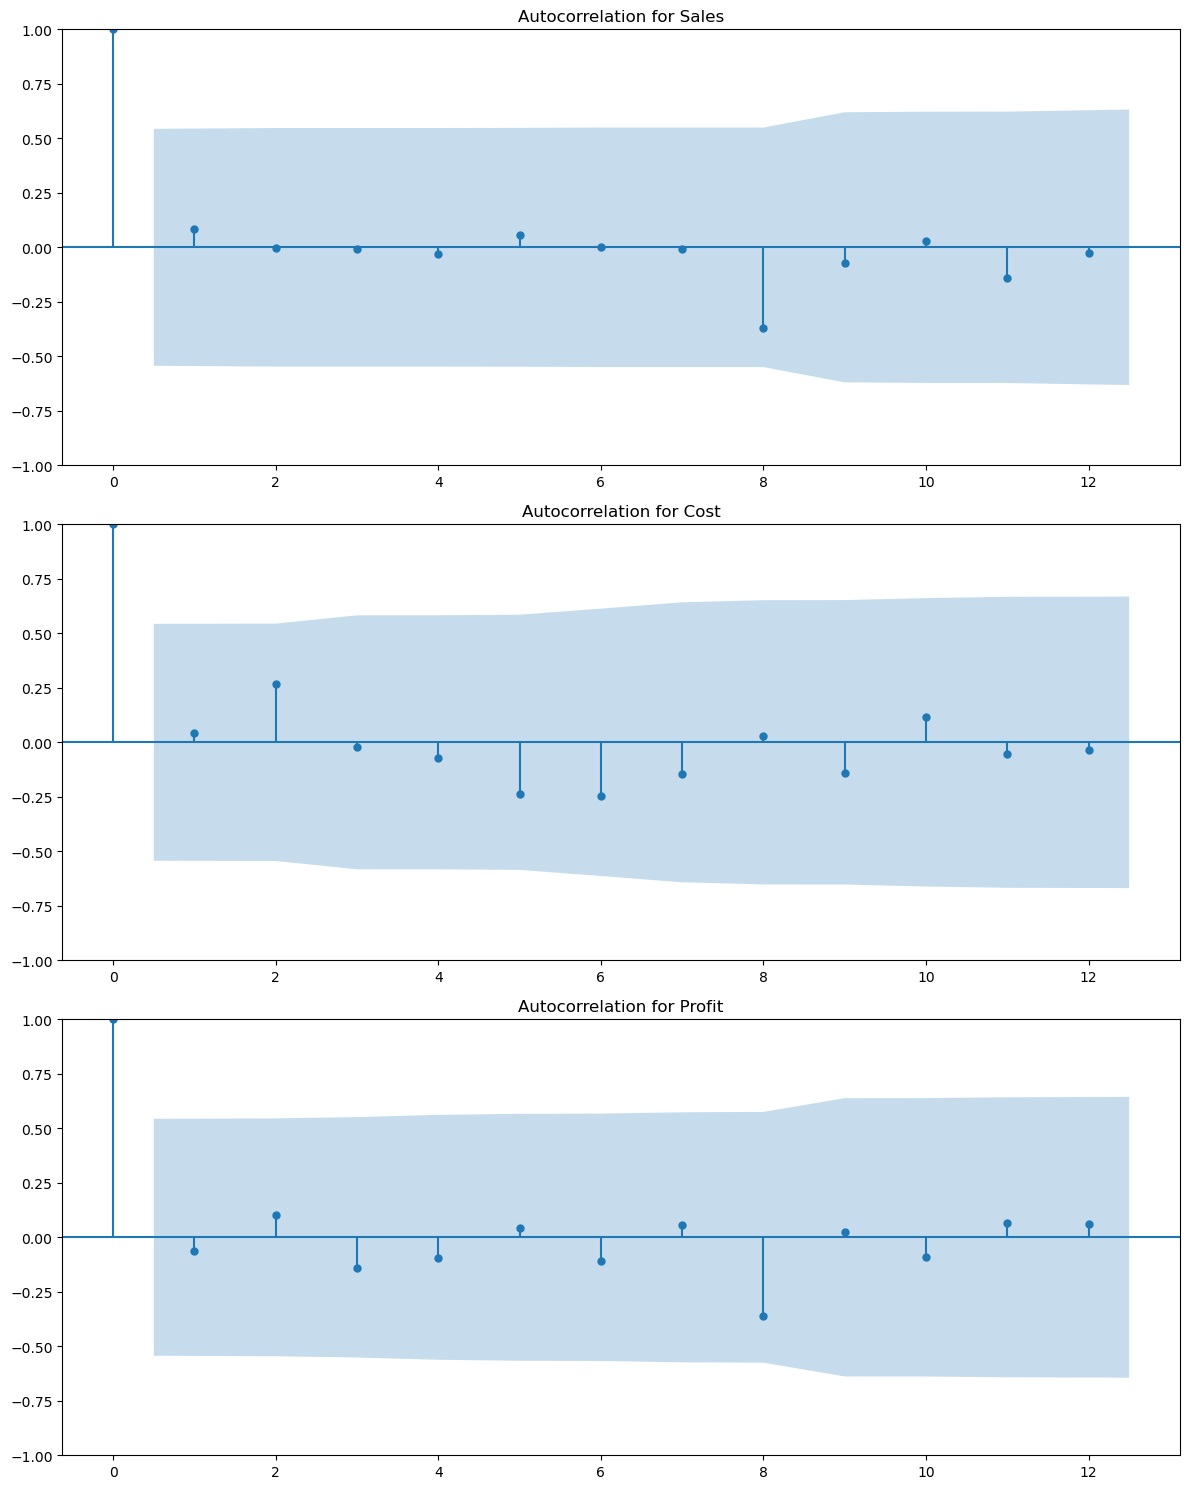

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

# Plotting autocorrelation for Sales, Cost, and Profit
fig, ax = plt.subplots(3, 1, figsize=(12, 15))

plot_acf(df['Sales'], ax=ax[0], lags=12, title="Autocorrelation for Sales")
plot_acf(df['Cost'], ax=ax[1], lags=12, title="Autocorrelation for Cost")
plot_acf(df['Profit'], ax=ax[2], lags=12, title="Autocorrelation for Profit")

plt.tight_layout()
plt.show()



### Deseasonalized data

#### Calculate centered moving average (CMA) and seasonal ratios for each metric

In [14]:
df['Sales_MA'] = df['Sales'].rolling(window=2, center=True).mean()
df['Sales_CMA'] = df['Sales_MA'].rolling(window=2).mean().shift(-1)
df['Sales_Ratio'] = (df['Sales'] / df['Sales_CMA']) * 100
df[['Sales', 'Sales_CMA', 'Sales_Ratio']]

,Sales,Sales_CMA,Sales_Ratio
Month,,,
2023-06-01,54350.0,NaN,NaN
2023-07-01,66417.0,59724.00,111.206550
2023-08-01,51712.0,57355.75,90.160097
2023-09-01,59582.0,65041.50,91.606128
2023-10-01,89290.0,72188.00,123.690918
2023-11-01,50590.0,59721.25,84.710216
2023-12-01,48415.0,47064.25,102.870013
2024-01-01,40837.0,40357.00,101.189385
2024-02-01,31339.0,39076.25,80.199610


#### Calculate median seasonal index and normalize it

In [20]:
def calculate_seasonal_index(df, column):
    # Calculate the median of the seasonal ratios
    median_index = df.groupby(df.index.month)[column].median()
    # Normalize the indices
    normalized_index = 100 * median_index / median_index.mean()
    return normalized_index

# Apply the function to each metric's ratio
sales_seasonal_index = calculate_seasonal_index(df, 'Sales_Ratio')

# Display the seasonal indices
seasonal_indices = pd.DataFrame({
    'Month': sales_seasonal_index.index,
    'Sales Seasonal Index': sales_seasonal_index.values,
})
seasonal_indices.set_index('Month', inplace=True)
seasonal_indices

,Sales Seasonal Index
Month,
1,99.355792
2,78.746360
3,109.163790
4,95.790487
5,123.648791
6,NaN
7,109.191442
8,88.526360
9,89.946188


Apply deseasonalization to each metric

In [24]:
def deseasonalize(df, original_col, index_series):
    month_series = df.index.month  # Extract month from index
    df[f'{original_col}_Deseasonalized'] = df[original_col] * 100 / index_series[month_series].values

deseasonalize(df, 'Sales', sales_seasonal_index); df

,Cost,Sales,Profit,Sales_MA,Sales_CMA,Sales_Ratio,Sales_Deseasonalized
Month,,,,,,,
2023-06-01,35027.0,54350.0,19323.0,NaN,NaN,NaN,NaN
2023-07-01,48065.0,66417.0,18352.0,60383.5,59724.00,111.206550,60826.195243
2023-08-01,18370.0,51712.0,33342.0,59064.5,57355.75,90.160097,58414.239633
2023-09-01,37480.0,59582.0,22102.0,55647.0,65041.50,91.606128,66241.828711
2023-10-01,23390.0,89290.0,65900.0,74436.0,72188.00,123.690918,73520.216031
2023-11-01,24200.0,50590.0,26390.0,69940.0,59721.25,84.710216,60823.394493
2023-12-01,13748.0,48415.0,34667.0,49502.5,47064.25,102.870013,47932.811926
2024-01-01,16720.0,40837.0,24117.0,44626.0,40357.00,101.189385,41101.780883
2024-02-01,23905.0,31339.0,7434.0,36088.0,39076.25,80.199610,39797.394881


Correcting the computation of trend and cyclic effects

In [32]:
time_index = np.arange(len(df)).reshape(-1, 1)

def compute_trend_and_cycle_corrected(df, column):
    # Linear Regression to fit trend on deseasonalized data
    model = LinearRegression()
    deseasonalized_data = df[column].dropna().values.reshape(-1, 1)
    valid_time_index = time_index[:len(deseasonalized_data)]
    model.fit(valid_time_index, deseasonalized_data)
    
    trend_values = model.predict(time_index)
    df[f'{column}_Trend'] = trend_values.ravel()  # Flatten array to fit into DataFrame
    
    cyclic_effect = df[column] / df[f'{column}_Trend'] * 100
    df[f'{column}_Cyclic'] = cyclic_effect

compute_trend_and_cycle_corrected(df, 'Sales_Deseasonalized'); df

,Cost,Sales,Profit,Sales_MA,Sales_CMA,Sales_Ratio,Sales_Deseasonalized,Sales_Deseasonalized_Trend,Sales_Deseasonalized_Cyclic
Month,,,,,,,,,
2023-06-01,35027.0,54350.0,19323.0,NaN,NaN,NaN,NaN,64542.490562,NaN
2023-07-01,48065.0,66417.0,18352.0,60383.5,59724.00,111.206550,60826.195243,62537.578935,97.263431
2023-08-01,18370.0,51712.0,33342.0,59064.5,57355.75,90.160097,58414.239633,60532.667308,96.500356
2023-09-01,37480.0,59582.0,22102.0,55647.0,65041.50,91.606128,66241.828711,58527.755680,113.180196
2023-10-01,23390.0,89290.0,65900.0,74436.0,72188.00,123.690918,73520.216031,56522.844053,130.071686
2023-11-01,24200.0,50590.0,26390.0,69940.0,59721.25,84.710216,60823.394493,54517.932426,111.565850
2023-12-01,13748.0,48415.0,34667.0,49502.5,47064.25,102.870013,47932.811926,52513.020799,91.277956
2024-01-01,16720.0,40837.0,24117.0,44626.0,40357.00,101.189385,41101.780883,50508.109172,81.376598
2024-02-01,23905.0,31339.0,7434.0,36088.0,39076.25,80.199610,39797.394881,48503.197544,82.051075


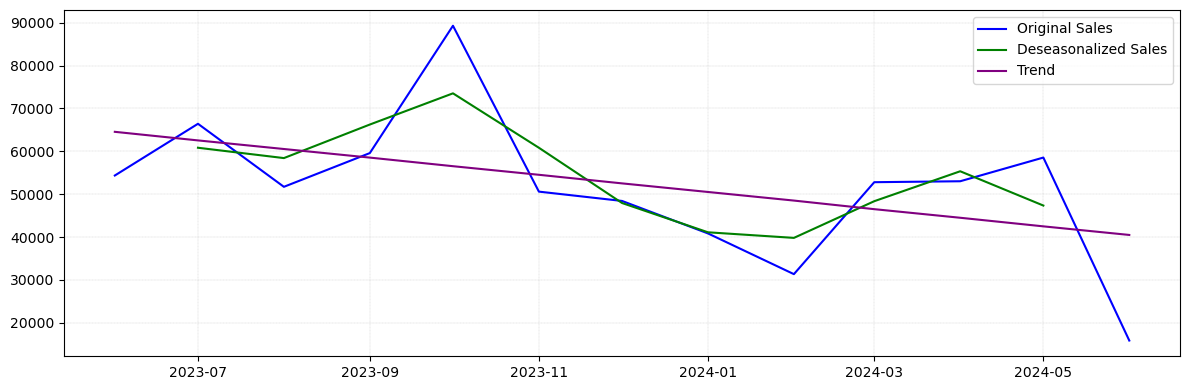

In [43]:
plt.figure(figsize = (12, 4))
plt.plot(df.index, df['Sales'], label='Original Sales', color='blue')
plt.plot(df.index, df['Sales_Deseasonalized'], label='Deseasonalized Sales', color='green')
plt.plot(df.index, df['Sales_Deseasonalized_Trend'], label='Trend', color='purple')
plt.grid(True, linestyle='--', linewidth=0.2)
plt.legend()
plt.tight_layout()
plt.show()


### Forecasting

In [51]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

data  = pd.read_excel('../data/baraka_hygienics_2023-24.xlsx', sheet_name="Expenditure per year")
df = data.groupby('Years').apply(lambda x: pd.Series({'Cost':  x['Total'].sum(),
                                                      'Sales': x['Sales'].sum(),
                                                      'Profit': x['Profit'].sum()
                                                     }), 
                                 include_groups=False).reset_index().rename(columns ={'Years': 'Month'})

df.set_index('Month', inplace=True)
df.index.freq = 'MS'  # Setting the monthly start frequency

In [52]:
# Corrected future months date range
future_months = pd.date_range(start=df.index.max() + pd.DateOffset(months=1), periods=3, freq='MS')

**Simple Exponential Smoothing (SES)**

In [64]:
ses_forecasts = {}
for column in ['Cost', 'Sales', 'Profit']:
    ses_model = SimpleExpSmoothing(df[column], initialization_method="heuristic").fit(optimized=True)
    ses_forecasts[column] = ses_model.forecast(3)
ses_forecast_df = pd.DataFrame(ses_forecasts, index=future_months); ses_forecast_df

,Cost,Sales,Profit
2024-07-01,24661.162873,41809.202758,29261.064752
2024-08-01,24661.162873,41809.202758,29261.064752
2024-09-01,24661.162873,41809.202758,29261.064752


**Holt's Linear Trend Model with alternative initialization method**


In [63]:
holt_forecasts = {}
for column in ['Cost', 'Sales', 'Profit']:
    holt_model = Holt(df[column], initialization_method="heuristic").fit(optimized=True)
    holt_forecasts[column] = holt_model.forecast(3)
holt_forecast_df = pd.DataFrame(holt_forecasts, index=future_months); holt_forecast_df

,Cost,Sales,Profit
2024-07-01,17652.625030,34685.157684,25368.270892
2024-08-01,15600.307435,32344.786539,25081.050754
2024-09-01,13547.989840,30004.415394,24793.830617


**ARIMA Model**

In [65]:

arima_forecasts = {}
arima_order = (1, 1, 1)  # This is a common starting point, but may need tuning based on AIC/BIC criteria
for column in ['Cost', 'Sales', 'Profit']:
    arima_model = ARIMA(df[column], order=arima_order).fit()
    arima_forecasts[column] = arima_model.forecast(3)
arima_forecast_df = pd.DataFrame(arima_forecasts, index=future_months); arima_forecast_df

,Cost,Sales,Profit
2024-07-01,23777.578324,27700.079710,14340.917576
2024-08-01,24093.028829,34194.668472,3630.577383
2024-09-01,24145.276101,37754.111465,9263.648064


**Plotting the results**


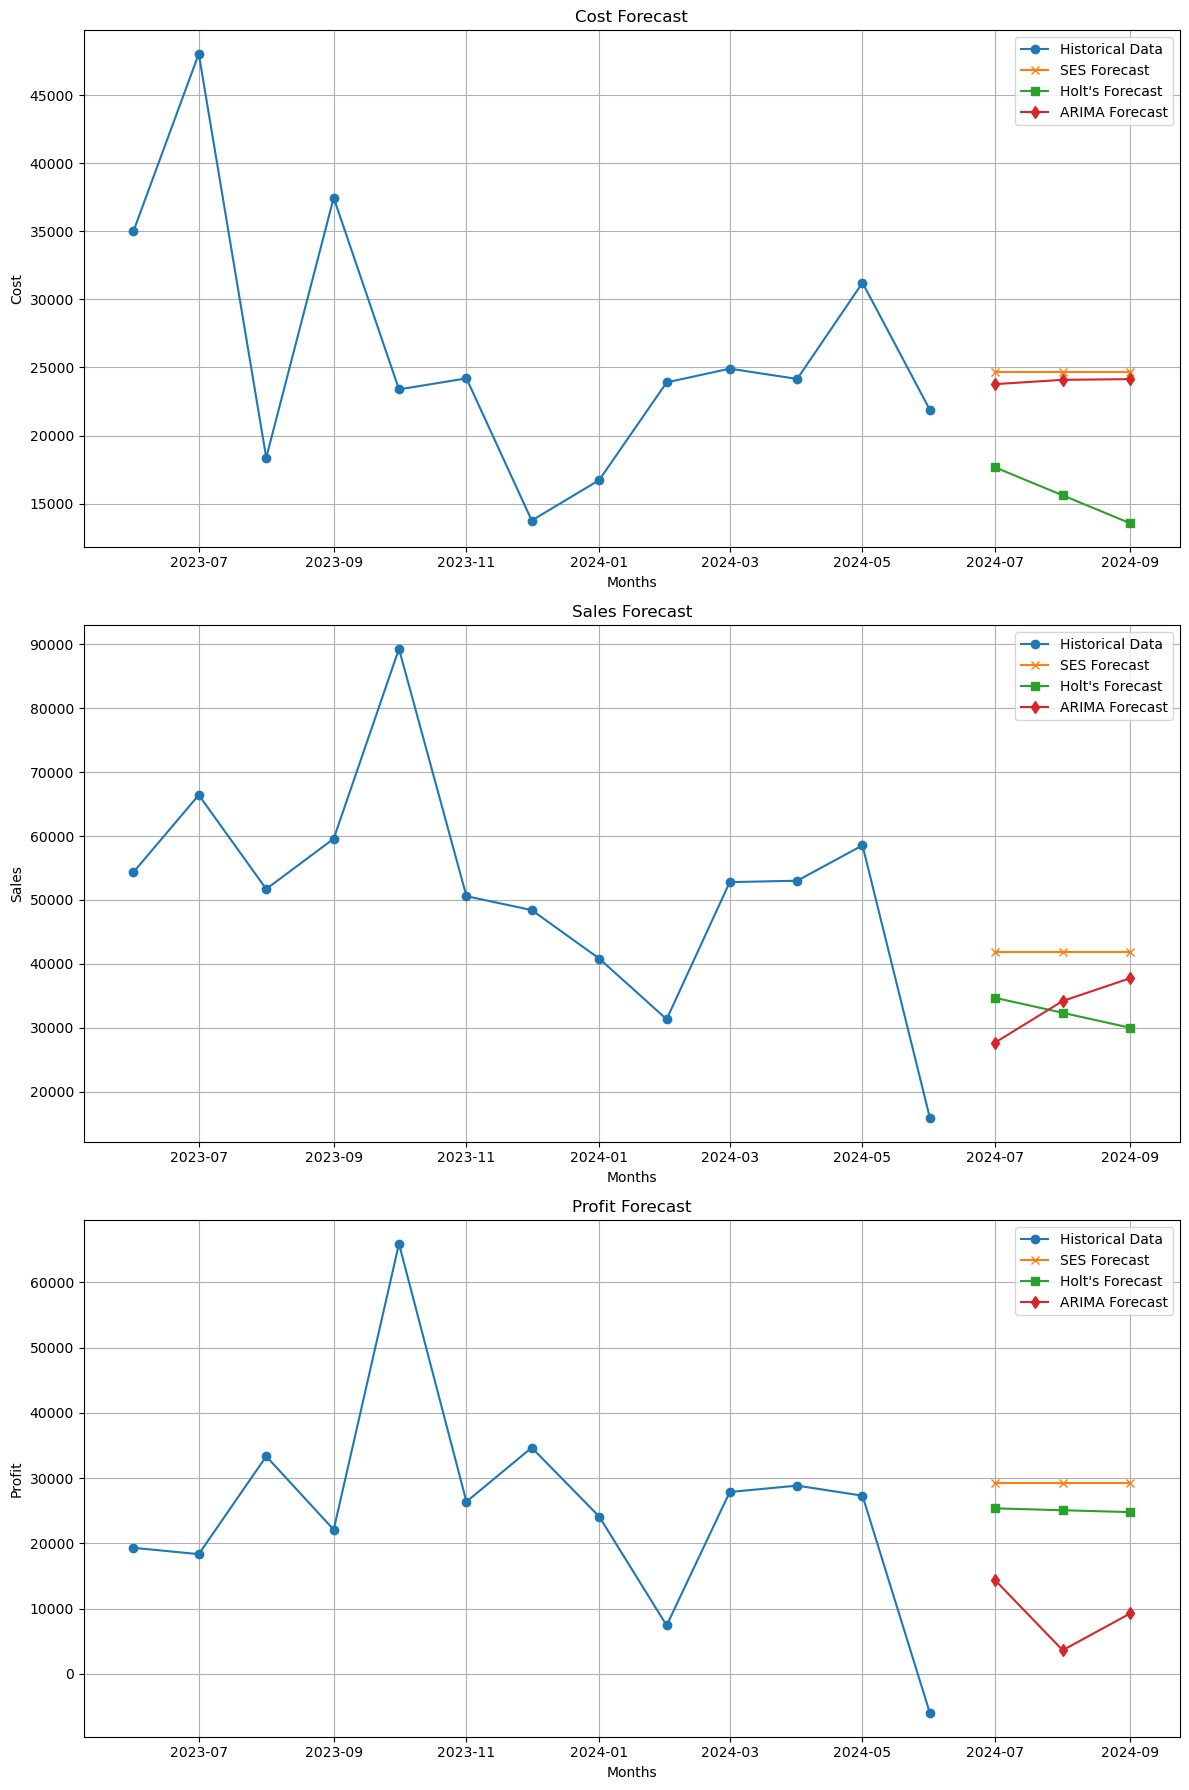

In [62]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))

for i, column in enumerate(['Cost', 'Sales', 'Profit']):
    # Plot historical data
    axes[i].plot(df.index, df[column], label='Historical Data', marker='o')
    # Plot SES forecast
    axes[i].plot(ses_forecast_df.index, ses_forecast_df[column], label='SES Forecast', marker='x')
    # Plot Holt's forecast
    axes[i].plot(holt_forecast_df.index, holt_forecast_df[column], label='Holt\'s Forecast', marker='s')
    # Plot ARIMA forecast
    axes[i].plot(arima_forecast_df.index, arima_forecast_df[column], label='ARIMA Forecast', marker='d')
    # Titles and labels
    axes[i].set_title(f'{column} Forecast')
    axes[i].set_xlabel('Months')
    axes[i].set_ylabel(column)
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()